# Explorativ Data Analyse

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
from IPython.display import display

sns.set()

In [2]:
df_data = pd.read_csv('data/ecommerce-data.zip', encoding='ISO-8859-1')

In [3]:
df_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


Lad os først forstå dataset.

Hvor mange rækker er der?

In [4]:
print(f'Antal transaktioner: {len(df_data)}')

Antal transaktioner: 541909


Har vi dubletter?

In [5]:
n_duplicates = len(df_data[df_data.duplicated()])
print(f'Antallet af dubletter: {n_duplicates}')

Antallet af dubletter: 5268


Der er nogle enkelte dubletter. Disse vil ødelægge vores statistikker, så vi sletter dem.

In [6]:
df_data[df_data.duplicated()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,12/1/2010 11:49,2.95,17920.0,United Kingdom
...,...,...,...,...,...,...,...,...
541675,581538,22068,BLACK PIRATE TREASURE CHEST,1,12/9/2011 11:34,0.39,14446.0,United Kingdom
541689,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,12/9/2011 11:34,2.49,14446.0,United Kingdom
541692,581538,22992,REVOLVER WOODEN RULER,1,12/9/2011 11:34,1.95,14446.0,United Kingdom
541699,581538,22694,WICKER STAR,1,12/9/2011 11:34,2.10,14446.0,United Kingdom


In [7]:
n_before = len(df_data)
df_data.drop_duplicates(inplace=True)
n_after = len(df_data)
print(f'Slettet {n_before - n_after} dubletter.')

Slettet 5268 dubletter.


Hvor mange værdier manger vi?

In [8]:
df_na = pd.DataFrame(df_data.isnull().sum(), columns=['NumberOfMissingValues']).T
df_na

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
NumberOfMissingValues,0,0,1454,0,0,0,135037,0


In [9]:
n_transactions_with_no_cust_info = df_na['CustomerID'][0]
pct_transactions_no_cust = n_transactions_with_no_cust_info / len(df_data) * 100
print(f'Andel af transaktioner uden kunde-ID: {pct_transactions_no_cust:.2f}%')

Andel af transaktioner uden kunde-ID: 25.16%


**OBS!** Der er relativ mange transaktioner uden kunde-ID.
Forklaring kunne være at kunde-ID er kun sat til transaktioner fra forbrugere
mens grossister ikke har en kunde-ID. Bekræft denne hypotese.

## Split data i to DateFrames

Data er joinet. Vi splitter det op for at få et bedre overblik.

In [10]:
df_invoices = df_data[['StockCode', 'InvoiceNo']].groupby(['InvoiceNo']).count()
df_invoices = df_invoices.rename(columns={'StockCode': 'NumberOfItems'})

In [11]:
df_data['Revenue'] = df_data['Quantity'] * df_data['UnitPrice']
df_invoices['TotalRevenue'] = df_data[['Revenue', 'InvoiceNo']].groupby(['InvoiceNo']).sum()

In [12]:
# Antager at kunde, land og dato er angivet på faktura-niveau
df_invoices['CustomerID'] = df_data[['CustomerID', 'InvoiceNo']].groupby(['InvoiceNo']).first()
df_invoices['HasCustomerID'] = df_invoices[['CustomerID']].isna() == False
df_invoices['CustomerID'] = df_invoices.CustomerID.map(lambda v: -1 if pd.isna(v) else int(v)).astype('category')

df_invoices['Country'] = df_data[['Country', 'InvoiceNo']].groupby(['InvoiceNo']).first()

df_invoices['Date'] = df_data[['InvoiceDate', 'InvoiceNo']].groupby(['InvoiceNo']).first().astype('datetime64[ns]')
df_invoices['Year'] = pd.DatetimeIndex(df_invoices['Date']).year
df_invoices['Month'] = pd.DatetimeIndex(df_invoices['Date']).month
df_invoices['DayOfWeek'] = pd.to_datetime(df_invoices['Date']).dt.day_name()
df_invoices['YearAndMonth'] = pd.to_datetime(df_invoices['Date']).dt.to_period('M')

In [13]:
df_invoices.reset_index(inplace=True)

In [14]:
df_invoices.head()

,InvoiceNo,NumberOfItems,TotalRevenue,CustomerID,HasCustomerID,Country,Date,Year,Month,DayOfWeek,YearAndMonth
0,536365,7,139.12,17850,True,United Kingdom,2010-12-01 08:26:00,2010,12,Wednesday,2010-12
1,536366,2,22.20,17850,True,United Kingdom,2010-12-01 08:28:00,2010,12,Wednesday,2010-12
2,536367,12,278.73,13047,True,United Kingdom,2010-12-01 08:34:00,2010,12,Wednesday,2010-12
3,536368,4,70.05,13047,True,United Kingdom,2010-12-01 08:34:00,2010,12,Wednesday,2010-12
4,536369,1,17.85,13047,True,United Kingdom,2010-12-01 08:35:00,2010,12,Wednesday,2010-12


In [15]:
df_invoice_lines = df_data[['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'UnitPrice', 'Revenue']]

In [16]:
df_invoice_lines.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,15.30
1,536365,71053,WHITE METAL LANTERN,6,3.39,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,20.34


## Faktura nummer (InvoiceNo)

Lad os først undersøge de enkelte kolonner.

In [17]:
df_invoices.InvoiceNo

0         536365
1         536366
2         536367
3         536368
4         536369
          ...   
25895    C581484
25896    C581490
25897    C581499
25898    C581568
25899    C581569
Name: InvoiceNo, Length: 25900, dtype: object

Nogle fakturanumre har et C foran. Hvorfor?

In [18]:
df_invoices['AllDigits'] = df_invoices.InvoiceNo.map(lambda v: v.isdigit())

In [19]:
df_invoices

,InvoiceNo,NumberOfItems,TotalRevenue,CustomerID,HasCustomerID,Country,Date,Year,Month,DayOfWeek,YearAndMonth,AllDigits
0,536365,7,139.12,17850,True,United Kingdom,2010-12-01 08:26:00,2010,12,Wednesday,2010-12,True
1,536366,2,22.20,17850,True,United Kingdom,2010-12-01 08:28:00,2010,12,Wednesday,2010-12,True
2,536367,12,278.73,13047,True,United Kingdom,2010-12-01 08:34:00,2010,12,Wednesday,2010-12,True
3,536368,4,70.05,13047,True,United Kingdom,2010-12-01 08:34:00,2010,12,Wednesday,2010-12,True
4,536369,1,17.85,13047,True,United Kingdom,2010-12-01 08:35:00,2010,12,Wednesday,2010-12,True
...,...,...,...,...,...,...,...,...,...,...,...,...
25895,C581484,1,-168469.60,16446,True,United Kingdom,2011-12-09 09:27:00,2011,12,Friday,2011-12,False
25896,C581490,2,-32.53,14397,True,United Kingdom,2011-12-09 09:57:00,2011,12,Friday,2011-12,False
25897,C581499,1,-224.69,15498,True,United Kingdom,2011-12-09 10:28:00,2011,12,Friday,2011-12,False
25898,C581568,1,-54.75,15311,True,United Kingdom,2011-12-09 11:57:00,2011,12,Friday,2011-12,False


Interessant. Indtægt er negativt. Måske indikerer 'C'-et en kreditnota?
Kan vi bekræfte den antagelse?

In [20]:
df_invoices[df_invoices.AllDigits == False][['TotalRevenue']].describe().T

,count,mean,std,min,25%,50%,75%,max
TotalRevenue,3839.0,-235.749359,3209.245653,-168469.6,-41.375,-16.85,-7.95,11062.06


Det er ikke alle steder hvor det er negativt. Lad os finde faktura med positiv indtjening.

In [21]:
df_invoices[(df_invoices.AllDigits == False) & (df_invoices.TotalRevenue >= 0)]

,InvoiceNo,NumberOfItems,TotalRevenue,CustomerID,HasCustomerID,Country,Date,Year,Month,DayOfWeek,YearAndMonth,AllDigits
22061,A563185,1,11062.06,-1,False,United Kingdom,2011-08-12 14:50:00,2011,8,Friday,2011-08,False


Der er faktura som starter med A. Hvad mon det betyder?

In [22]:
df_invoice_lines[df_invoice_lines.InvoiceNo.str.startswith('A')]

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Revenue
299982,A563185,B,Adjust bad debt,1,11062.06,11062.06
299983,A563186,B,Adjust bad debt,1,-11062.06,-11062.06
299984,A563187,B,Adjust bad debt,1,-11062.06,-11062.06


Det lader til at der er tale om afskrivningsposter.

In [23]:
filter_A = df_invoices.InvoiceNo.str.startswith('A')
filter_C = df_invoices.InvoiceNo.str.startswith('C')
n_invoices_A = len(df_invoices[filter_A])
n_invoices_C = len(df_invoices[filter_C])
n_invoices_rest = len(df_invoices[~filter_A & ~filter_C])
n_invoices_total = len(df_invoices)

print(f'Antal faktura: {n_invoices_total}')
print(f'Antal faktura med A-nummer: {n_invoices_A}')
print(f'Antal faktura med C-nummer: {n_invoices_C}')
print(f'Antal faktura uden prefix: {n_invoices_rest}')

Antal faktura: 25900
Antal faktura med A-nummer: 3
Antal faktura med C-nummer: 3836
Antal faktura uden prefix: 22061


Umiddelbart ser det ud som om at der er tre typer af faktura:
- Salgsfaktura (intet bogstav i fakturanummer)
- Kreditnota (fakturanummer starter med et C)
- Afskrivning (fakturanummer starter med et A)

In [24]:
def get_type(invoice_no):
    if invoice_no[0] == 'A':
        return 'Write-Off'
    if invoice_no[0] == 'C':
        return 'Credit Note'
    return 'Standard'

df_invoices['Type'] = df_invoices.InvoiceNo.map(get_type)

In [25]:
df_invoices.head()

,InvoiceNo,NumberOfItems,TotalRevenue,CustomerID,HasCustomerID,Country,Date,Year,Month,DayOfWeek,YearAndMonth,AllDigits,Type
0,536365,7,139.12,17850,True,United Kingdom,2010-12-01 08:26:00,2010,12,Wednesday,2010-12,True,Standard
1,536366,2,22.20,17850,True,United Kingdom,2010-12-01 08:28:00,2010,12,Wednesday,2010-12,True,Standard
2,536367,12,278.73,13047,True,United Kingdom,2010-12-01 08:34:00,2010,12,Wednesday,2010-12,True,Standard
3,536368,4,70.05,13047,True,United Kingdom,2010-12-01 08:34:00,2010,12,Wednesday,2010-12,True,Standard
4,536369,1,17.85,13047,True,United Kingdom,2010-12-01 08:35:00,2010,12,Wednesday,2010-12,True,Standard


## Omsætning per faktura

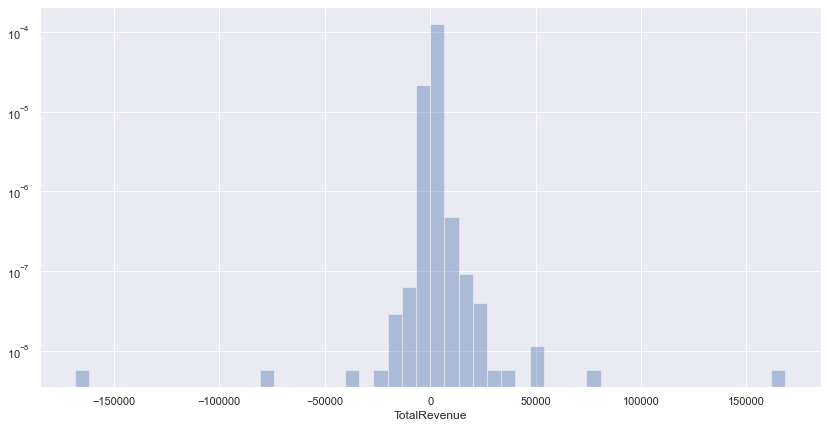

In [26]:
fig, ax = plt.subplots(figsize=(14, 7))
sns.distplot(df_invoices.TotalRevenue, kde=False, norm_hist=True, ax=ax)
ax.set_yscale('log')

Der er faktura med store positive og negative tal. Lad os kigge på dem.

In [27]:
df_invoices[(df_invoices.TotalRevenue < -50000) | (df_invoices.TotalRevenue > 50000)]

,InvoiceNo,NumberOfItems,TotalRevenue,CustomerID,HasCustomerID,Country,Date,Year,Month,DayOfWeek,YearAndMonth,AllDigits,Type
2303,541431,1,77183.60,12346,True,United Kingdom,2011-01-18 10:01:00,2011,1,Tuesday,2011-01,True,Standard
18776,574941,101,52940.94,-1,False,United Kingdom,2011-11-07 17:42:00,2011,11,Monday,2011-11,True,Standard
19468,576365,99,50653.91,-1,False,United Kingdom,2011-11-14 17:55:00,2011,11,Monday,2011-11,True,Standard
22025,581483,1,168469.60,16446,True,United Kingdom,2011-12-09 09:15:00,2011,12,Friday,2011-12,True,Standard
22510,C541433,1,-77183.60,12346,True,United Kingdom,2011-01-18 10:17:00,2011,1,Tuesday,2011-01,False,Credit Note
25895,C581484,1,-168469.60,16446,True,United Kingdom,2011-12-09 09:27:00,2011,12,Friday,2011-12,False,Credit Note


- Faktura 541431 blev krediteret -- kreditnota C541433
- Faktura 581483 blev krediteret -- kreditnota C581484
- Faktura 574941 og 576365 ser umiddelbart OK ud. Der er dog ingen kunde-ID på dem. Det kunne tænkes at det er salg til grosister.

### Omsætning per måned

In [28]:
filter_with_cust_id = df_invoices.HasCustomerID
df_rev_data = df_invoices[filter_with_cust_id][['TotalRevenue', 'YearAndMonth']].groupby(['YearAndMonth']).sum()
df_rev_data = df_rev_data.rename(columns={'TotalRevenue': 'Kunder'})

filter_without_cust_id = df_invoices.HasCustomerID == False
df_rev_data['Løssalg'] = df_invoices[filter_without_cust_id][['TotalRevenue', 'YearAndMonth']].groupby(['YearAndMonth']).sum()

df_rev_data.reset_index(inplace=True)

In [29]:
df_rev_data.T

,0,1,2,3,4,5,6,7,8,9,10,11,12
YearAndMonth,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12
Kunder,552373,473732,435534,578576,425223,647012,606863,573112,615078,929356,973306,1.12682e+06,341539
Løssalg,194351,84716.7,61492.3,103438,67145.2,75082.4,83114.7,107045,66308.4,88240.5,96061.9,329331,91161.6


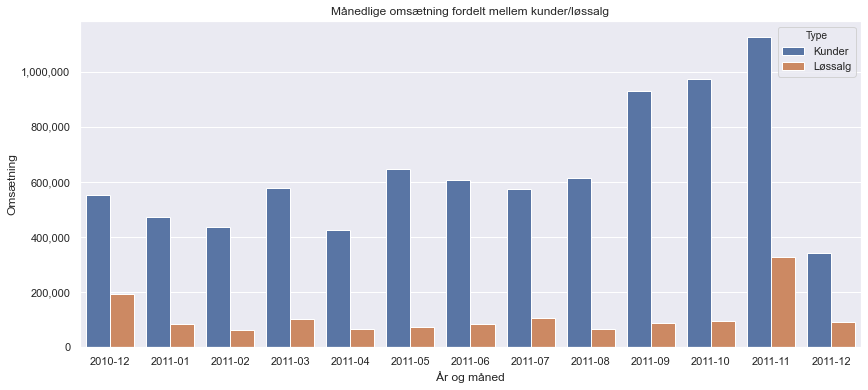

In [30]:
fig, ax = plt.subplots(figsize=(14, 6))

df_plot_data = df_rev_data.melt('YearAndMonth', var_name='Type', value_name='Value')
sns.barplot(x='YearAndMonth', y='Value', hue='Type', data=df_plot_data, ax=ax)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_xlabel('År og måned')
ax.set_ylabel('Omsætning')
ax.set_title('Månedlige omsætning fordelt mellem kunder/løssalg');

- Faste kunder står for langt størstedelen af den månedlige omsætningen. Faste kunder er grosister? Måske skal vi fokusere på dem.
- Omsætning er størst i november. Kan skyldes Black Friday. Efterfulgt af september og oktober. Måske skal grosister fylde lagre i månederne op til Black Friday.
- Vi skal nok se bort fra tallene i december 2011 da vi kun har data til og med den 9. december 2011

### Omsætning per kunde

In [31]:
df_invoice_customers = df_invoices[df_invoices.HasCustomerID == True]

df_rev_by_cust = df_invoice_customers[['CustomerID', 'InvoiceNo']].groupby('CustomerID').count()
df_rev_by_cust = df_rev_by_cust.rename(columns={'InvoiceNo': 'NumberOfInvoices'})

df_rev_by_cust['TotalRevenue'] = df_invoice_customers[['CustomerID', 'TotalRevenue']].groupby('CustomerID').sum()
df_rev_by_cust['AvgRevenuePerInvoice'] = df_rev_by_cust['TotalRevenue'] / df_rev_by_cust['NumberOfInvoices']
df_rev_by_cust['Country'] = df_invoice_customers[['CustomerID', 'Country']].groupby('CustomerID').first()

In [32]:
df_rev_by_cust.head()

,NumberOfInvoices,TotalRevenue,AvgRevenuePerInvoice,Country
CustomerID,,,,
-1,0,0.00,NaN,NaN
12346,2,0.00,0.000000,United Kingdom
12347,7,4310.00,615.714286,Iceland
12348,4,1797.24,449.310000,Finland
12349,1,1757.55,1757.550000,Italy


In [33]:
total_result = df_invoices.TotalRevenue.sum()
total_result_customers = df_rev_by_cust.TotalRevenue.sum()

print(f'Samlet resultat på tværs af kunder og løssalg: {total_result:,.0f} £.')
print(f'Samlet resultat på registrede kunder {total_result_customers:,.0f} £.')

Samlet resultat på tværs af kunder og løssalg: 9,726,007 £.
Samlet resultat på registrede kunder 8,278,519 £.


Lad os kigge på vores største kunder.

In [34]:
df_plot_data = df_rev_by_cust.sort_values('TotalRevenue', ascending=False)
n_top = 20
df_plot_data = df_plot_data[['TotalRevenue']].iloc[0:n_top]
# df_plot_data.T

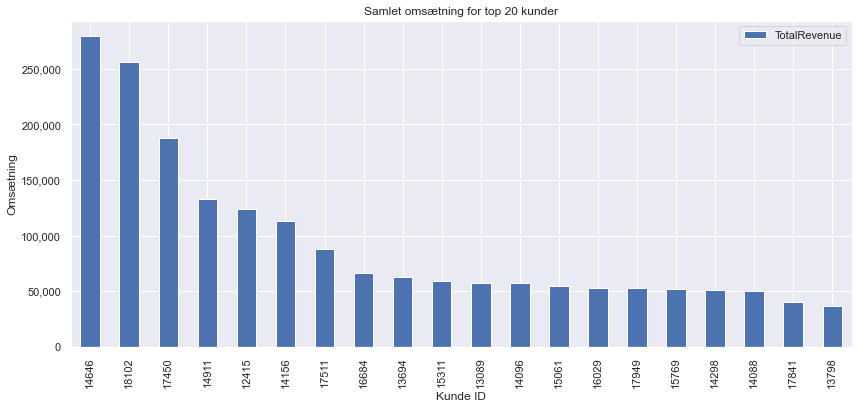

In [35]:
fig, ax = plt.subplots(figsize=(14, 6))
df_plot_data.plot(kind='bar', ax=ax)

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_xlabel('Kunde ID')
ax.set_ylabel('Omsætning')
ax.set_title(f'Samlet omsætning for top {n_top} kunder');

### Omsætning per land

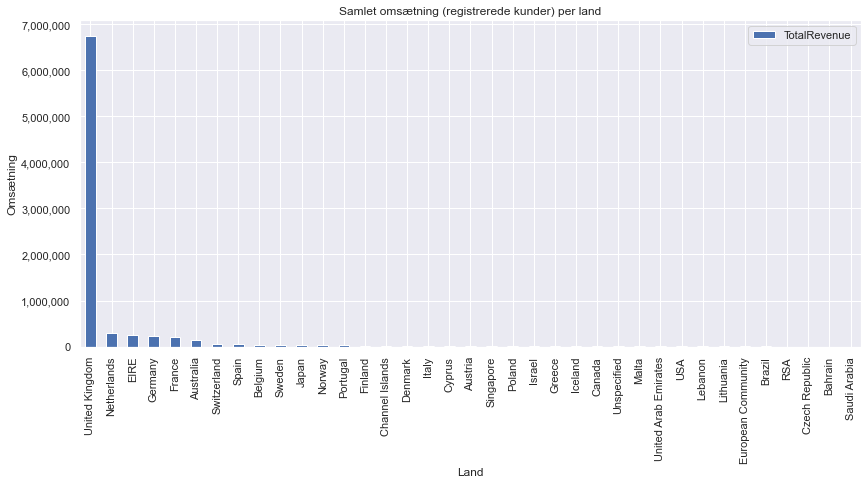

In [36]:
fig, ax = plt.subplots(figsize=(14, 6))

(df_rev_by_cust[['TotalRevenue', 'Country']]
   .groupby('Country')
   .sum()
   .sort_values('TotalRevenue', ascending=False)
   .plot(kind='bar', ax=ax)
)
# ax.set_yscale('log')
ax.set_xlabel('Land')
ax.set_ylabel('Omsætning')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_title('Samlet omsætning (registrerede kunder) per land');

- Salg til kunder i England dominerer.

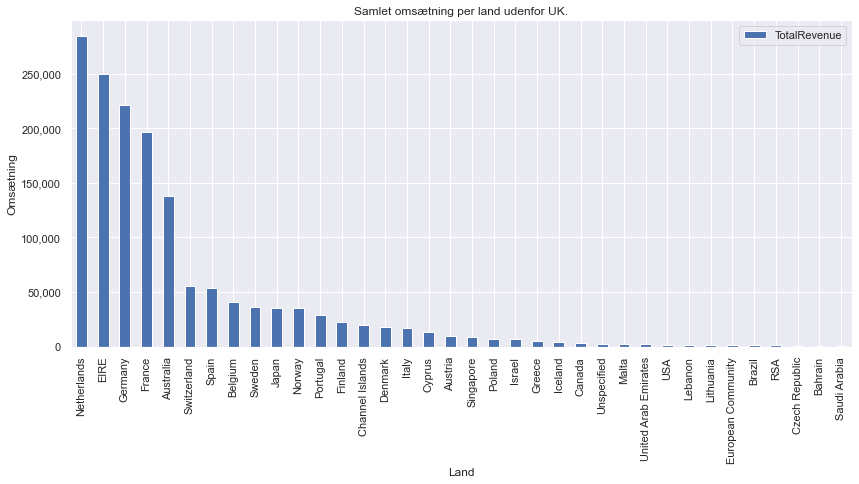

In [37]:
fig, ax = plt.subplots(figsize=(14, 6))
(df_rev_by_cust[df_rev_by_cust.Country != 'United Kingdom'][['TotalRevenue', 'Country']]
   .groupby('Country')
   .sum()
   .sort_values('TotalRevenue', ascending=False)
   .plot(kind='bar', ax=ax)
)
#ax.set_yscale('log')
ax.set_xlabel('Land')
ax.set_ylabel('Omsætning')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_title('Samlet omsætning per land udenfor UK.');

### Kunder per land

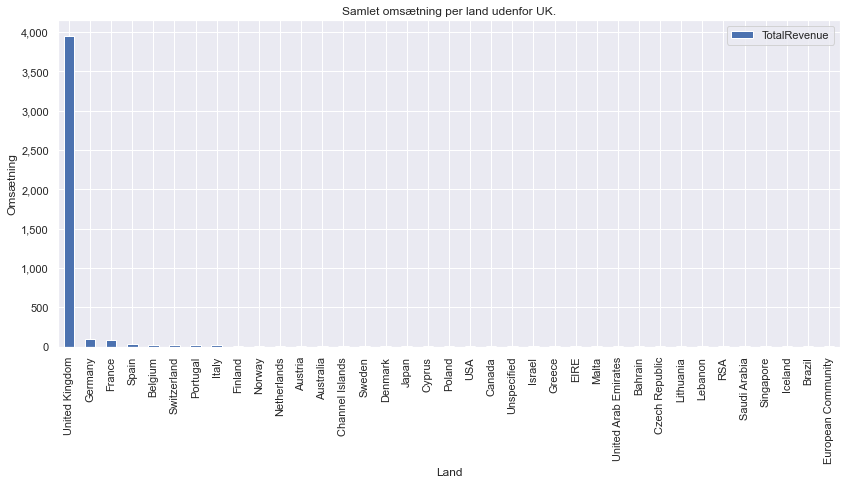

In [38]:
fig, ax = plt.subplots(figsize=(14, 6))
(df_rev_by_cust[['TotalRevenue', 'Country']]
   .groupby('Country')
   .count()
   .sort_values('TotalRevenue', ascending=False)
   .plot(kind='bar', ax=ax)
)
# ax.set_yscale('log')
ax.set_xlabel('Land')
ax.set_ylabel('Omsætning')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_title('Samlet omsætning per land udenfor UK.');

- Som forventet, de fleste kunder er fra England. Det kan godt betale sig at fokusere på UK.

## Segmentering af kunder

Segmentering kan give os en bedre forståelse af behov hos kunderne. Grosister køber på baggrund af behov end de gør af lyst.

- Muligheder for vækstpotentiale blandt eksisterende kunder bl.a. ved at vide hvad de har behov for før de bestiller
- Proaktiv og data-drevet markedsføring for at tiltrække flere kunder.

Da jeg ikke har demokrafiske data, kan man forsøger sig med at segmentere udfra købsadfærd. Jeg prøver RFM-metoden (Recency, Frequency and Monetary) som går ud på at kategorisere kunder baseret på tre parametre ([kilde](https://www.putler.com/rfm-analysis/)):
- Recency: hvornår en kunde sidst har købt noget (antal dage siden sidste købsdato)
- Frequency: antallet af ordrer
- Monetary: total omsætning

Jeg mangler blot at udregne Recency.

In [39]:
df_rev_by_cust['LatestPurchaseDate'] = df_invoices.groupby('CustomerID')[['Date']].max()

# Bemærk: Antal dage siden sidste fakturadato er en simplificering
today = df_invoices.Date.max() + pd.DateOffset(days=2)
df_rev_by_cust['Recency'] = df_rev_by_cust['LatestPurchaseDate'].map(lambda v: (today - v).days)

In [40]:
df_rfm_data = df_rev_by_cust[df_rev_by_cust.TotalRevenue > 0][['Recency', 'NumberOfInvoices', 'TotalRevenue']].rename(
    columns={'Recency': 'RValue', 'NumberOfInvoices': 'FValue', 'TotalRevenue': 'MValue'}
)

In [41]:
df_rfm_data.head()

,RValue,FValue,MValue
CustomerID,,,
12347,3,7,4310.00
12348,76,4,1797.24
12349,20,1,1757.55
12350,311,1,334.40
12352,37,11,1545.41


Nu kan jeg udregne en score for hver af de tre parametre. Jeg bruger en scoringsmetode via fem kvartiler som i beskrevet i [Putler](https://www.putler.com/rfm-analysis/).

In [42]:
df_rfm_data['RScore'] = pd.qcut(df_rfm_data['RValue'], q=5, labels=[1, 2, 3, 4, 5]).astype(int)

# Rank data: https://stackoverflow.com/questions/20158597/how-to-qcut-with-non-unique-bin-edges
df_rfm_data['FScore'] = pd.qcut(df_rfm_data['FValue'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5]).astype(int)

df_rfm_data['MScore'] = pd.qcut(df_rfm_data['MValue'], q=5, labels=[1, 2, 3, 4, 5]).astype(int)

In [43]:
df_rfm_data.head()

,RValue,FValue,MValue,RScore,FScore,MScore
CustomerID,,,,,,
12347,3,7,4310.00,1,4,5
12348,76,4,1797.24,4,3,4
12349,20,1,1757.55,2,1,4
12350,311,1,334.40,5,1,2
12352,37,11,1545.41,3,5,4


Man kan kombinere Frequency-Score og Monetary-Score fordi de samlet set udtrykker  hvor meget en kunde køber.
Jeg bruger gennemsnittet af de to scores.

In [44]:
df_rfm_data['FMScore'] = np.round((df_rfm_data['FScore'] + df_rfm_data['MScore']) / 2)
df_rfm_data['FMScore'] = df_rfm_data['FMScore'].astype(int)

Data er klar til segmentering. Man kan bruge en tabel til kategorisere sine kunder. Denne tabel er fra [Putler](https://www.putler.com/rfm-analysis/):

| Customer Segment            | Recency | F & M |
|-----------------------------|---------|-------|
| Champions                   | 4-5     | 4-5   |
| Loyal Customers             | 2-5     | 3-5   |
| Potential Loyalist          | 3-5     | 1-3   |
| Recent Customers            | 4-5     | 0-1   |
| Promising                   | 3-4     | 0-1   |
| Customers Needing Attention | 2-3     | 2-3   |
| About To Sleep              | 2-3     | 0-2   |
| At Risk                     | 0-2     | 2-5   |
| Can’t Lose Them             | 0-1     | 4-5   |
| Hibernating                 | 1-2     | 1-2   |
| Lost                        | 0-2     | 0-2   |


<img src="https://uploads-ssl.webflow.com/5d28e43c1770c36fefd51134/5d2e5c092663b9516caadca8_11%20RFM%20Customer%20Segments%20-%20Retail.png" width="600" />

[Kilde](https://blog.hmscommerce.com/blog-posts/the-rfm-model-for-proven-segmentation)


*Bemærk:* Nul er ikke en mulig score ifølge deres egen artikel men tabellen indeholder 0. Retter det til da det muligvis er tale om slåfejl.

In [45]:
segment_table = {
  'Champions': [(4, 5), (4, 5)],
  'Loyal Customers': [(2, 5), (3, 5)],
  'Potential Loyalist': [(3, 5), (1, 3)],
  'Recent Customers': [(4, 5), (1, 2)],
  'Promising': [(3, 4), (1, 2)],   
  'Customers Needing Attention': [(2, 3), (2, 3)],
  'About To Sleep': [(2, 3), (1, 3)],
  'At Risk': [(1, 3), (2, 5)],
  'Can\'t Lose Them': [(1, 2), (4, 5)],
  'Hibernating': [(1, 2), (1, 2)],
  'Lost': [(1, 3), (1, 3)]
}

In [46]:
score_segment_map = dict()
for k, v in segment_table.items():
    r_range = v[0][0], v[0][1]+1
    fm_range = v[1][0], v[1][1]+1
    for i in range(*r_range):
        for j in range(*fm_range):
            score_segment_map[f'{i}{j}'] = k

In [47]:
df_rfm_data['RFMScore'] = df_rfm_data['RScore'].astype(str) + df_rfm_data['FMScore'].astype(str)

In [48]:
df_rfm_data['Segment'] = df_rfm_data['RFMScore'].map(lambda v: score_segment_map[v])

In [49]:
df_rfm_data

,RValue,FValue,MValue,RScore,FScore,MScore,FMScore,RFMScore,Segment
CustomerID,,,,,,,,,
12347,3,7,4310.00,1,4,5,4,14,Can't Lose Them
12348,76,4,1797.24,4,3,4,4,44,Loyal Customers
12349,20,1,1757.55,2,1,4,2,22,Lost
12350,311,1,334.40,5,1,2,2,52,Recent Customers
12352,37,11,1545.41,3,5,4,4,34,At Risk
...,...,...,...,...,...,...,...,...,...
18280,279,1,180.60,5,2,1,2,52,Recent Customers
18281,182,1,80.82,5,2,1,2,52,Recent Customers
18282,9,3,176.60,1,3,1,2,12,Lost


Hvordan er fordelingen af kunderne i de forskellige segmenter?

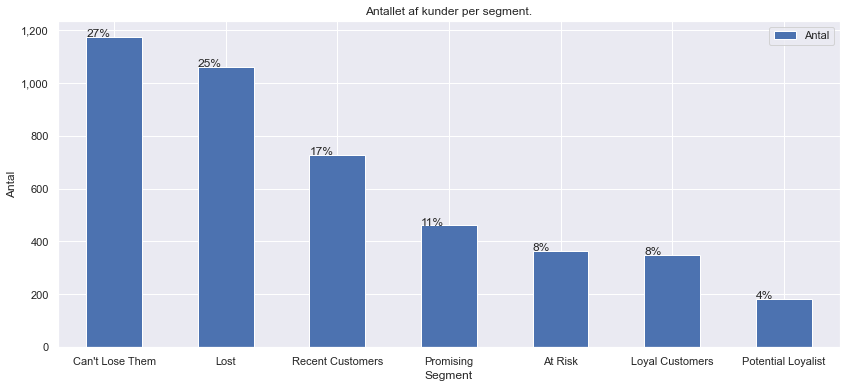

In [50]:
fig, ax = plt.subplots(figsize=(14, 6))

df_plot_data = (df_rfm_data[['RValue', 'Segment']]
       .groupby('Segment')
       .count()
       .rename(columns={'RValue':'Antal'})
       .sort_values('Antal', ascending=False)
)

df_plot_data.plot(kind='bar', ax=ax)

total_count = df_plot_data['Antal'].sum()
pct_vals = list(df_plot_data['Antal'] / total_count)
for i, p in enumerate(ax.patches):
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{pct_vals[i]:.0%}', (x, y + height + 0.01))

for tick in ax.get_xticklabels():
    tick.set_rotation(0)
ax.set_xlabel('Segment')
ax.set_ylabel('Antal')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

ax.set_title('Antallet af kunder per segment.');

Can't Lose Them: 27% af kunderne har lav-mellem R-score men høj FM-score
 - Lav-mellem R-score: det er noget tid siden kunderne i denne gruppe har købt noget i forhold til de andre kunder.
 - Høj FM-score: Har tidligere handlet flere gange og brugt mange penge.
 - Undersøg hvad man kan gøre for at få dem til at handle noget oftere. Spørg om deres behov via et spørgeskemaundersøgelse.
 
Lost: 25% af kunderne har lav R og FM scores.
 - Lav R-score: lang tid siden sidst handlet.
 - Lav FM-score: køber ikke ikke så tit og generelt bruger de lidt penge.
 - Man kan undersøge om det kan svare sig at bruge tid på disse kunder. Måske er de engangskunder som handler rundt i forskellige webshops. Er de pris-sensitive?
 
Recent: 17% af kunderne har høj R-score men lav-mellem FM-score
 - En stor andel af kunderne har handlet fornyelig, men har ikke brugt så store summer.
 - Man kan prøve at påvirke dem så de får et godt indtryk af webshoppen. De kan nogle gode velkomst-tilbud, gratis vareprøver mm.

Promising: 11% af kunderne har mellem R-score men lav FM-score
 - Kundegruppen har handlet for ikke længe siden, men har ikke handlet så meget og bruger ikke så mange penge.
 - Lidt ligesom de nye kunder i Recent.
 
At Risk: 8% af kunder har lav R-score men mellem-høj FM-score
 - Kunder som vi ikke har set i lang tid. Tidligere har de brugt store summer og handlet ofte.
 - Lidt ligesom *Can't Lose Them* segmentet.
 
Loyal Customers: 8% af kunderne har RFM-score i den mellem-høje ende.
 - Kundegruppen har vi set for nylig, handler ofte og bruge mange penge på vores forrretning.
 - Værd at kigge på hvilke produkter de køber for at blive klog på deres behov.
 - Nogle af disse kunder kan måske lokkes til at lave produkt-reviews. Kan muligvis være interesseret i at købe dyrere varer.
  
Potential Loyalist: 4% af kunderne har mellem-høj R-score mens FM-score ligger lavere end de loyale kunder.
 - De har handlet i nyere end den loyale kundegruppe men bruger ikke så mange penge.